In [359]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

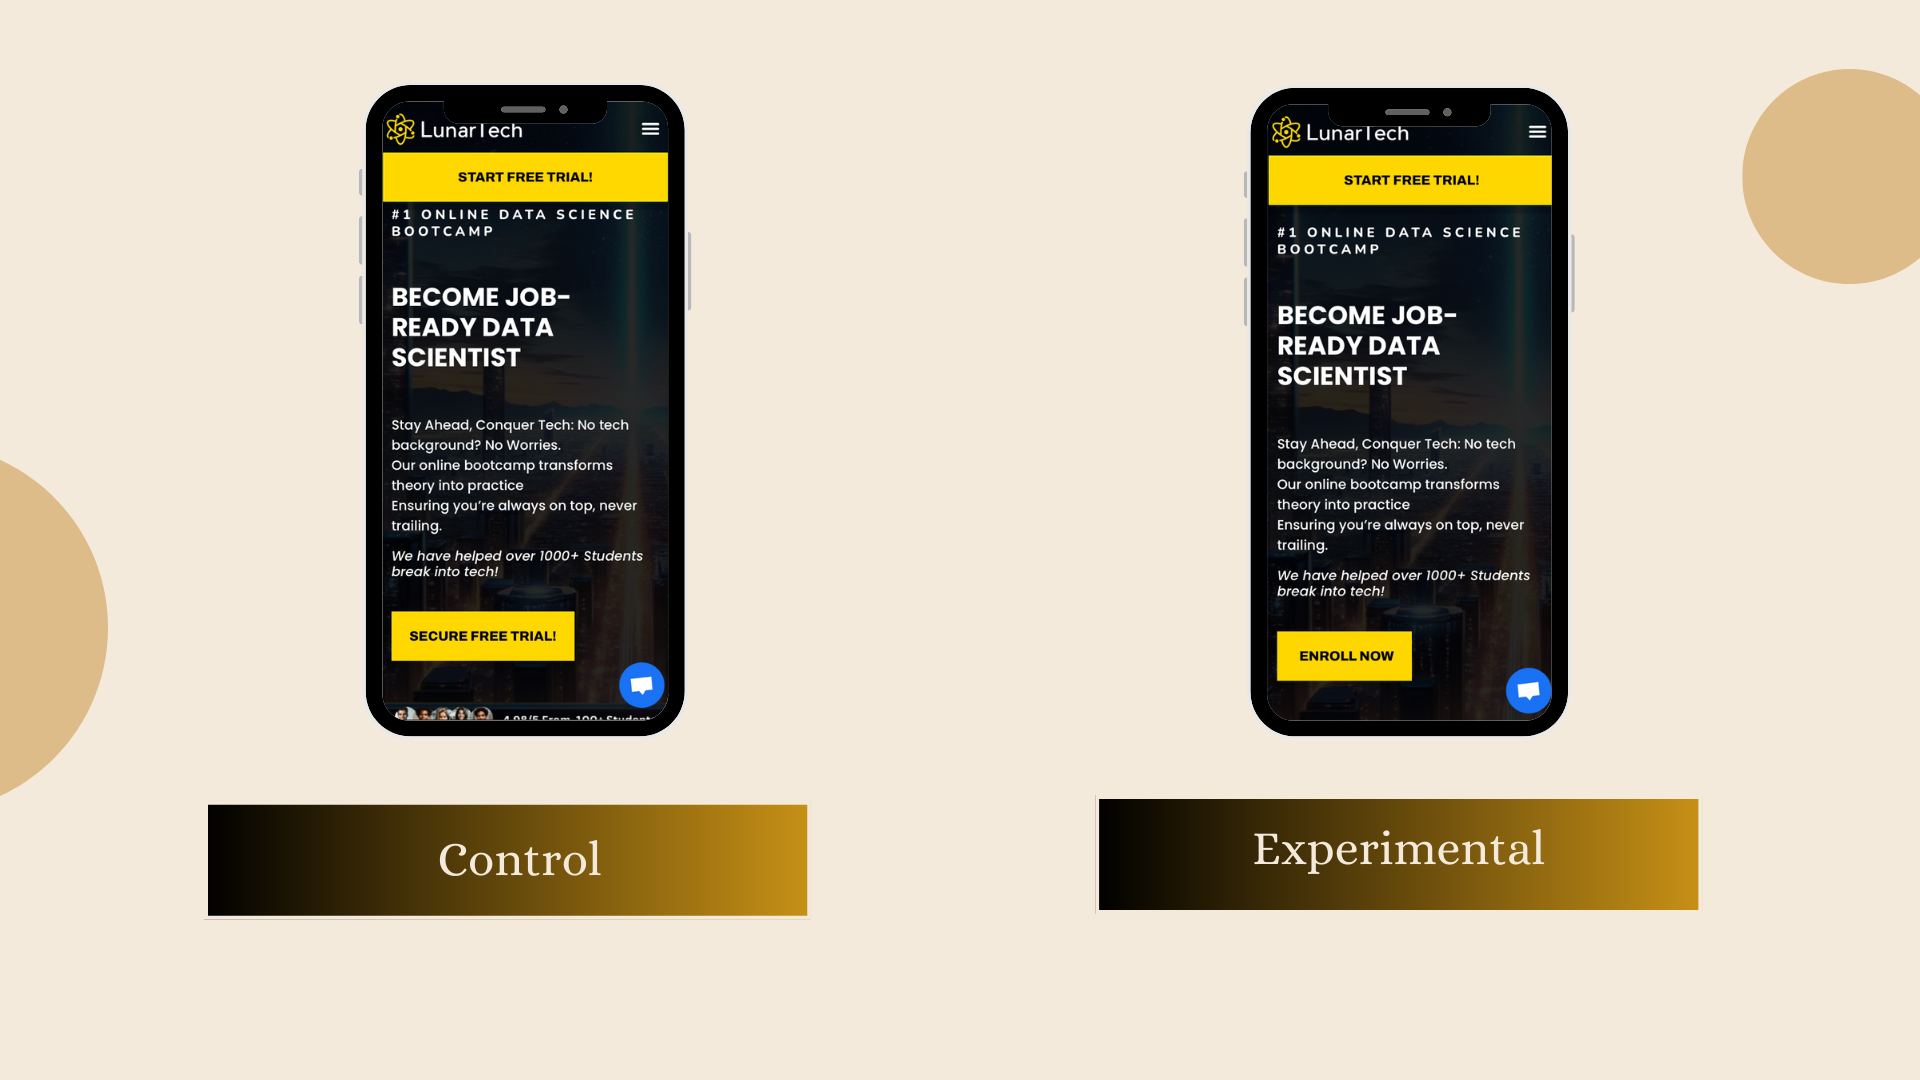

In [360]:
# Importing images to show the control and experimental 
from IPython.display import Image
Image("image.png")


## Loading our CTR Data for AB Test

In [362]:
# Loading the first 5 rows of data
df_ab_test = pd.read_csv('ab_test_click_data (1).csv')
df_ab_test.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [363]:
# Loading the last 5 rows
df_ab_test.tail()

,user_id,click,group,timestamp
19995,19996,1,con,NaN
19996,19997,1,con,NaN
19997,19998,1,con,NaN
19998,19999,0,con,NaN
19999,20000,1,con,NaN


In [364]:
# Statisctical analysis of the dataframe
df_ab_test.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


In [365]:
# Convert column names to title case
df_ab_test.columns = df_ab_test.columns.str.title()

In [366]:
# inspecting the dataframe
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   User_Id    20000 non-null  int64 
 1   Click      20000 non-null  int64 
 2   Group      20000 non-null  object
 3   Timestamp  10000 non-null  object
dtypes: int64(2), object(2)
memory usage: 625.1+ KB


In [367]:
# To check missing values
df_ab_test.isnull().sum()


User_Id          0
Click            0
Group            0
Timestamp    10000
dtype: int64

In [368]:
# Dealing with the missing data
df_ab_test['Timestamp'] = df_ab_test['Timestamp'].fillna(method='ffill')  # Forward fill
df_ab_test.tail()

,User_Id,Click,Group,Timestamp
19995,19996,1,con,2024-01-07 22:39:00
19996,19997,1,con,2024-01-07 22:39:00
19997,19998,1,con,2024-01-07 22:39:00
19998,19999,0,con,2024-01-07 22:39:00
19999,20000,1,con,2024-01-07 22:39:00


In [369]:
# to check the clicks category size
print(df_ab_test.groupby("Group").sum("Click"))

         User_Id  Click
Group                  
con    150005000   1989
exp     50005000   6116


In [370]:
# To calculate total clicks and no-clicks for each group
summary = df_ab_test.groupby('Group')['Click'].agg(
    Total_Clicks='sum',
    Total_No_Clicks=lambda x: (x == 0).sum()
).reset_index()

print(summary)
# Calculate total responses for percentage calculation
summary['Total_Responses'] = summary['Total_Clicks'] + summary['Total_No_Clicks']

# Calculate percentages
summary['Percentage_Clicks'] = summary['Total_Clicks'] / summary['Total_Responses'] * 100
summary['Percentage_No_Clicks'] = summary['Total_No_Clicks'] / summary['Total_Responses'] * 100
print(summary['Percentage_Clicks'])
print(summary['Percentage_No_Clicks'])


  Group  Total_Clicks  Total_No_Clicks
0   con          1989             8011
1   exp          6116             3884
0    19.89
1    61.16
Name: Percentage_Clicks, dtype: float64
0    80.11
1    38.84
Name: Percentage_No_Clicks, dtype: float64


## A bar chart showing the total clicks versus no-clicks in each group can provide a clear visual comparison of user engagement.

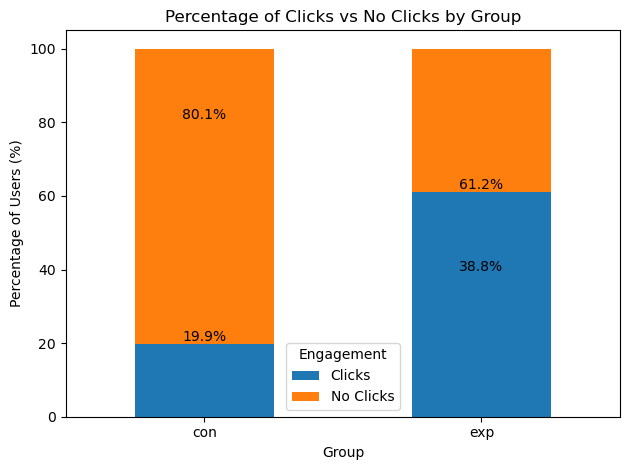

In [372]:
# To Plot the number of clicks
ax = summary.set_index('Group')[['Percentage_Clicks', 'Percentage_No_Clicks']].plot(kind='bar', stacked=True)

# Adding percentage labels on the bars
for p in ax.patches:
    # Get the height of the bar (percentage)
    height = p.get_height()
    # Get the x position of the bar
    x = p.get_x() + p.get_width() / 2
    # Add the percentage label
    ax.annotate(f'{height:.1f}%', (x, height), ha='center', va='bottom' if height > 0 else 'top')

plt.title('Percentage of Clicks vs No Clicks by Group')
plt.xlabel('Group')
plt.ylabel('Percentage of Users (%)')
plt.xticks(rotation=0)
plt.legend(title='Engagement', labels=['Clicks', 'No Clicks'])
plt.tight_layout()
plt.show()


# Parameters of Power Analysis

In power analysis, several key parameters are essential for determining the required sample size to detect an effect or assess the power of a statistical test:

1. **Effect Size (d)**: 
   - Magnitude of the difference or relationship expected. Larger effect sizes require smaller sample sizes for adequate power.

2. **Significance Level (α)**: 
   - Probability of rejecting the null hypothesis when it is true (Type I error). Commonly set at 0.05.

3. **Power (1 - β)**: 
   - Probability of correctly rejecting the null hypothesis when it is false. Typical power levels are 0.80 or 0.90.

4. **Sample Size (N)**: 
   - Total number of observations or participants in the study. This is often what power analysis aims to determine.

5. **Variability (σ)**: 
   - Standard deviation of the population or expected variability in the data. Higher variability typically requires a larger sample size.

6. **Study Design**: 
   - The specific statistical test used (e.g., t-test, ANOVA) affects calculations for power and sample size.

7. **Directionality**: 
   - Whether the hypothesis is one-tailed or two-tailed influences power calculations.


In [374]:
# Print the alpha and delta values
alpha = 0.05 # 5%
print("Alpha: significance level is:", alpha )

delta = 0.1 # 10%
print("Delta: minimum detectable effect is:", delta )

Alpha: significance level is: 0.05
Delta: minimum detectable effect is: 0.1


## Calculating total number of clicks per group by summing clicks

In [376]:
# Calculating the total number of clicks per group
N_con = df_ab_test[df_ab_test["Group"] == "con"].count()[0]
N_exp = df_ab_test[df_ab_test["Group"] == "exp"].count()[0]

# calculating the total number of clicks per group by summing 1's
X_con = df_ab_test.groupby("Group")["Click"].sum().loc["con"]
X_exp = df_ab_test.groupby("Group")["Click"].sum().loc["exp"]

# printing this for visibility
print(df_ab_test.groupby("Group")["Click"].sum())
print("Number of user in Control: ", N_con)
print("Number of users in Experimental: ", N_exp)
print("Number of CLicks in Control: ", X_con)
print("Number of CLicks in Experimental: ", X_exp)

Group
con    1989
exp    6116
Name: Click, dtype: int64
Number of user in Control:  10000
Number of users in Experimental:  10000
Number of CLicks in Control:  1989
Number of CLicks in Experimental:  6116


## Calculating Pooled Estimates for Clicks per Group

In [378]:
#Calculating the pooled estimates for each group
# computing the estimate of click probability per group
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
print("Pooled Click Probability:", p_pooled_hat)

Click Probability in Control Group: 0.1989
Click Probability in Experimental Group: 0.6116
Pooled Click Probability: 0.40525


## Calculating Pooled Variance

In [380]:
# Calculating the pooled variance
# computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)

p^_pooled is:  0.40525
pooled_variance is:  4.82044875e-05


## Calculating Standard Error and Test Statistics

In [382]:
# computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

# computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test is:", Test_stat)

# critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

Standard Error is:  0.006942945160376826
Test Statistics for 2-sample Z-test is: -59.44163326469381
Z-critical value from Standard Normal distribution:  1.959963984540054


## Calculating p_values of the Z-test
A low p-value (p ≤ 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
A high p-value (p > 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.

In [384]:
#calculating p value
p_value = 2 * norm.sf(abs(Test_stat))

# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.

    Arguments:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.

    Returns:
    - Prints the assessment of statistical significance.
    """

    # Print the rounded p-value to 3 decimal places
    print(f"P-value of the 2-sample Z-test: {(p_value)}")

    # Determine statistical significance
    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group.")
    else:
        print("There is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance. This implies that the changes in the experimental group do not have a substantial effect compared to the control group.")



is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group.


## Visualizing the distribution to illustrate the rejected region

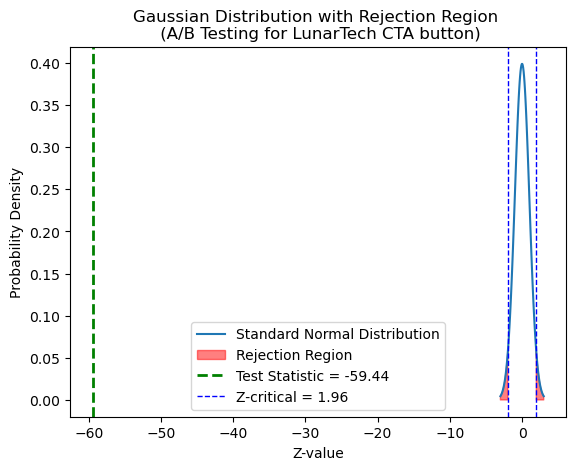

In [386]:
# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)


# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')
# Adding Test Statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')
# Adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for LunarTech CTA button)')
plt.legend()
# Show plot
plt.show()

## Calculating Confidence Interval of the test

In [388]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval
CI = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit, 3),  # Lower bound of the CI, rounded to 3 decimal places
    round((p_exp_hat - p_con_hat) + SE*Z_crit, 3)   # Upper bound of the CI, rounded to 3 decimal places
]

# Print the calculated confidence interval
print("Confidence Interval of the 2 sample Z-test is: ", CI)

# Here, the confidence interval provides a range of values within which the true difference between the experimental and control group proportions is likely to lie with a certain level of confidence (e.g., 95%).

Confidence Interval of the 2 sample Z-test is:  [0.399, 0.426]


## Testing for Practical Significance in A/B Testing

In [390]:
def is_Practically_significant(delta, CI_95):
    """
    We assess here if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE) parameter from the Power Analysis.

    Arguments:
    - delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.

    Returns:
    - Prints whether the experiment has practical significance based on the MDE and CI.
    """

    # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]

    # Check if the lower bound of the CI is greater than or equal to delta
    if delta >= lower_bound_CI:
        print(f"We have practical significance! \nWith MDE of {delta}, The difference between Control and Experimental group is practically significant.")
        return True
    else:
        print("We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant.")
        return False

# Call the function
significance = is_Practically_significant(delta, CI_95)
print("Lower bound of 95% confidence interval is: ", CI_95[0])


We have practical significance! 
With MDE of 0.1, The difference between Control and Experimental group is practically significant.
Lower bound of 95% confidence interval is:  0.04
